In [13]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import matplotlib.gridspec as gridspec

from spacepy import coordinates as coord
from spacepy.time import Ticktock

# from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D

import xflib as xflib

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from ray_interp_2d_grid_v2 import interp_ray_power
data = interp_ray_power(
                        ray_dir='/shared/users/asousa/WIPP/rays/2d/nightside/mode6/kp6/',
                        power_dir = '/shared/users/asousa/WIPP/WIPP_stencils/outputs/input_energies/',
                        tmax = 10,
                        flash_lat=40,
                        mlt=0,
                        dt=0.05,
                        f_low=200,
                        f_hi=30000,
                        max_dist=500,
                        n_sub_freqs=20,
                        Llims=[0,6],
                        NL = 300,
                        dlon = 1,
                        I0 = 10000
                        )



Loading freq: 200
Loading freq: 230
Loading freq: 270
Loading freq: 320
Loading freq: 370
Loading freq: 440
Loading freq: 510
Loading freq: 600
Loading freq: 700
Loading freq: 820
Loading freq: 960
Loading freq: 1120
Loading freq: 1310
Loading freq: 1530
Loading freq: 1790
Loading freq: 2090
Loading freq: 2450
Loading freq: 2860
Loading freq: 3350
Loading freq: 3920
Loading freq: 4580
Loading freq: 5360
Loading freq: 6270
Loading freq: 7330
Loading freq: 8570
Loading freq: 10030
Loading freq: 11720
Loading freq: 13710
Loading freq: 16040
Loading freq: 18750
Loading freq: 21930
Loading freq: 25650
Loading freq: 30000
Rotating to new longitudes
Loading previous powers
Starting interpolation
t =  0
t =  1
t =  2
t =  3
t =  4
t =  5
t =  6
t =  7
t =  8
t =  9
t =  10
t =  11
t =  12
t =  13
t =  14
t =  15
t =  16
t =  17
t =  18
t =  19
t =  20
t =  21
t =  22
t =  23
t =  24
t =  25
t =  26
t =  27
t =  28
t =  29
t =  30
t =  31
t =  32
t =  33
t =  34
t =  35
t =  36
t =  37
t =  38


In [10]:
def bulge(amlt, akp):
    '''cloning the fortran function here... I think I did this before, but whatever'''
    ahour_rad = 0.26179939
    ahrrad = 2.6179939e-1
    centroid=47.0/(akp+3.9)+11.3
    x=amlt-centroid
    if (x < -12.0):
        x=x+24.0    
    if (x > 12.0):
        x=x-24.0
    absx=abs(x)*ahrrad
    
    along=amlt*ahour_rad+1.5707963
    salong=np.sin(along)
    b1= 0.043*salong-0.4589
    b2=-0.361*salong+5.7464
    a8=(b1*akp+b2)*(1.0+np.exp(-1.5*absx*absx+0.08*absx-0.7))
    b3=-0.0243*salong+0.2464
    b4=-0.3137*salong-5.2214
    b5= 3.5817*salong+48.8114
    a9=b3*akp*akp + b4*akp+b5
    
    return a8, a9, centroid

In [65]:
with open('../outputs/movie_frames/inlat_40/movie_frames_kp6.pkl','rb') as f:
    data = pickle.load(f)

7.98150681167


<IPython.core.display.Javascript object>


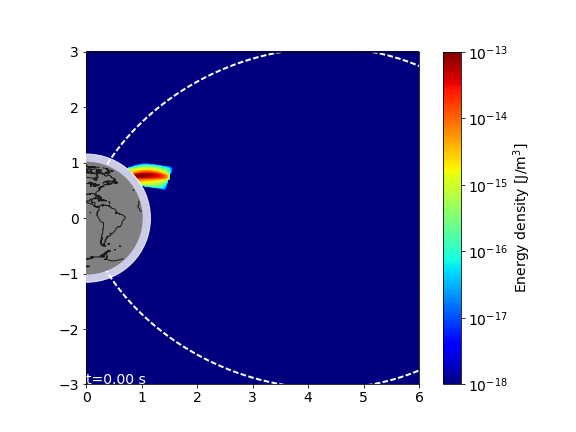

7.98150681167


<IPython.core.display.Javascript object>


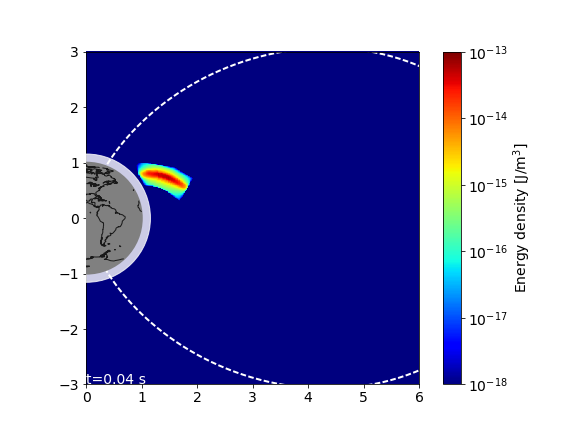

7.98150681167


<IPython.core.display.Javascript object>


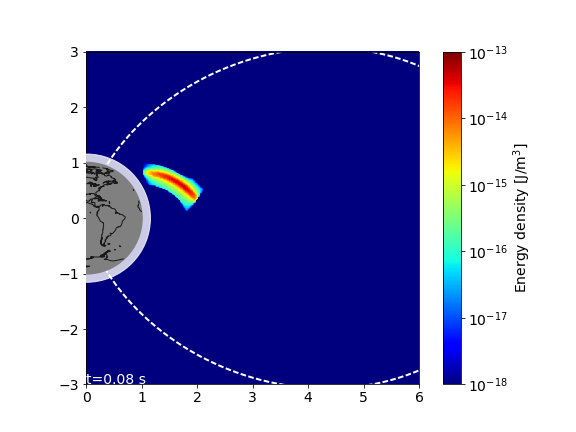

7.98150681167


<IPython.core.display.Javascript object>


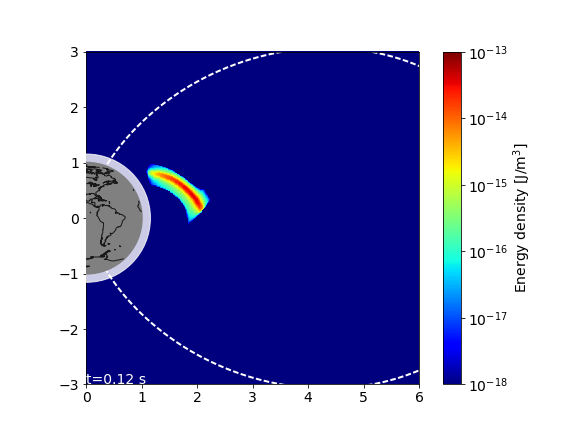

7.98150681167


<IPython.core.display.Javascript object>


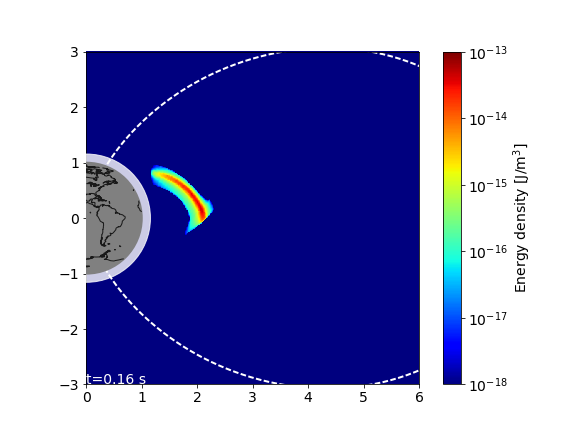

7.98150681167


<IPython.core.display.Javascript object>


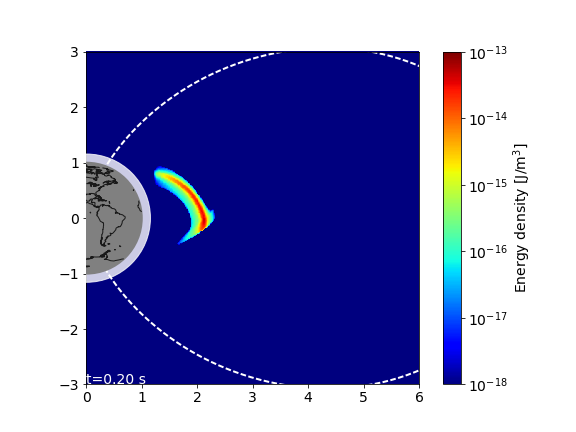

7.98150681167


<IPython.core.display.Javascript object>


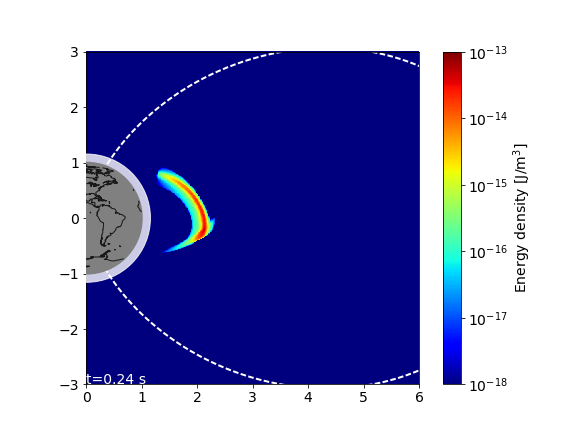

7.98150681167


<IPython.core.display.Javascript object>


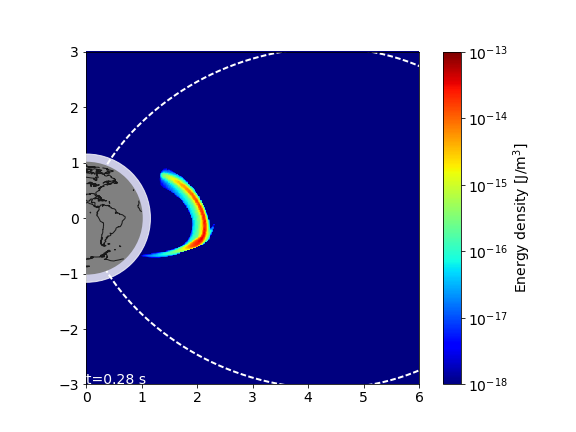

7.98150681167


<IPython.core.display.Javascript object>


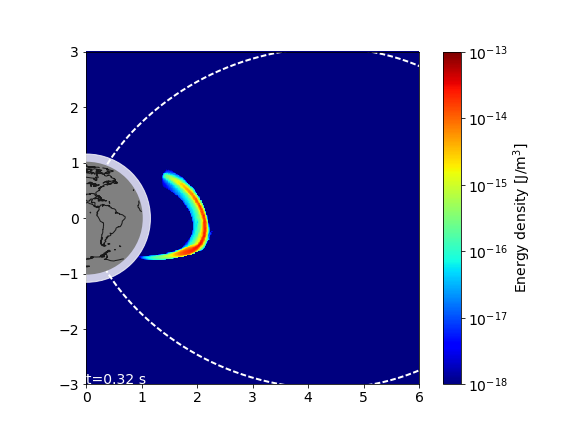

7.98150681167


<IPython.core.display.Javascript object>


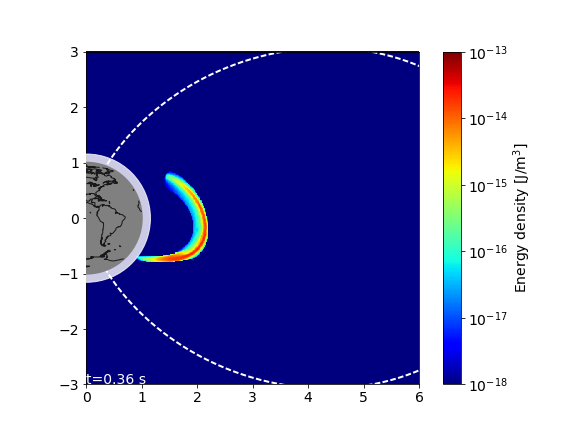

In [66]:
def plot_frame(data, t_ind, clims=None):
    # --------------- Latex Plot Beautification --------------------------
    fig_width = 7 
    fig_height = 5
    fig_size =  [fig_width+1,fig_height+1]
    params = {'backend': 'ps',
              'axes.labelsize': 14,
              'font.size': 14,
              'legend.fontsize': 14,
              'xtick.labelsize': 14,
              'ytick.labelsize': 14,
              'text.usetex': False,
              'figure.figsize': fig_size}
    plt.rcParams.update(params)
    # --------------- Latex Plot Beautification --------------------------
    # Constants
    Hz2Rad = 2.*np.pi
    D2R = np.pi/180.
    H_IONO_BOTTOM = 1e5
    H_IONO_TOP = 1e6

    R_E = 6371e3
    Kp = 0
    Lpp,_,_ = bulge(data['params']['mlt'], Kp)
    print Lpp
    ninterp = 800
    cm = plt.get_cmap('jet')
    
    Llims = data['params']['Llims']
    NL = data['params']['NL']
    
    xx = np.linspace(Llims[0], Llims[1], NL)
    zz = np.linspace(-Llims[1]/2., Llims[1]/2., NL)
    
    newx = np.linspace(Llims[0], Llims[1], ninterp)
    newz = np.linspace(-Llims[1]/2., Llims[1]/2., ninterp)

    newx = np.linspace(0, 6, ninterp)
    newz = np.linspace(-3, 3, ninterp)


#     Originally: nx, nz, nf, nt. 
#     Select time frame and um over freq axis for this plot
#     d = np.sum(data['data'][:,:,:,t], axis=-1)

    # nx, nx, nt. Select current timestep.
    d = data['data'][:,:,t]
#     logdata = np.log10(d)
#     logdata[np.isinf(logdata)] = -100


    px, pz = np.meshgrid(xx, zz)
    
    
    interp = interpolate.RegularGridInterpolator([xx, zz], d, bounds_error=False, fill_value=0)
    px, py = np.meshgrid(newx, newz)
    pts = zip(px.ravel(), py.ravel())
    logdata = np.log10(interp(pts)).reshape(len(newx), len(newz))
    logdata[np.isinf(logdata)] = -100

    # Load coastlines (for plotting)
    with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
        coast = pickle.load(file)
    
    maxlog = np.max([logdata])
    
    # Show about 5 orders of magnitude
    if clims is None:
        clims = [maxlog - 5, maxlog]

#     fig, ax = plt.subplots(1,1)
    fig = plt.figure()
    gs = gridspec.GridSpec(1,2, width_ratios=[1,0.05])
    gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
    
    ax = plt.subplot(gs[0])
    cax = plt.subplot(gs[1])

    # Plot the earth
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, linewidth=2,zorder=100)
    iono  = plt.Circle((0,0),(R_E + H_IONO_TOP)/R_E, color='w',alpha=0.8, zorder=99)
    ax.add_patch(earth)   
    ax.add_patch(iono)
        
    # Plot coastlines
    coastpoints = np.vstack([coast['lon']/90. + 0.3, coast['lat']/90.])
    coastr = np.linalg.norm(coastpoints, axis=0)
    coastmask = (coastr < 1) | (np.isnan(coastr))
    ax.plot(coastpoints[0,coastmask], coastpoints[1,coastmask],'k', zorder=101, alpha=0.8, linewidth=1)

    # Plot plasmapause fieldline:
    
    flats = np.arange(-80,80,1)*D2R
    fl_rad = Lpp*pow(np.cos(flats),2)
    ax.plot(fl_rad*np.cos(flats), fl_rad*np.sin(flats),'--',color='w',linewidth=2)
    
    # Plot data!
    p0 = ax.pcolorfast(newx, newz, logdata, vmin=clims[0], vmax=clims[1], cmap = cm)
    ax.set_aspect('equal')
    ax.set_xlim([newx[0],newx[-1]])
    ax.set_ylim([newz[0],newz[-1]])

    # Colorbar
    cb = plt.colorbar(p0, cax=cax)
    cticks = np.arange(clims[0],clims[1] + 1)
    cb.set_ticks(cticks)
    cticklabels = ['$10^{%d}$'%k for k in cticks]
    cb.set_ticklabels(cticklabels)
    cb.set_label('Energy density [J/m$^3$]') 
    
    fig.subplots_adjust(right=0.8)

    ax.text(newx[0], newz[0],'t=%1.2f s'%(t*data['params']['dt']), color='w')
    
ts = np.arange(0, 10, 1)
for t_ind, t in enumerate(ts):
    plot_frame(data, t, clims=[-18, -13])


In [60]:
d = np.random.rand(400,400,int(20/0.02))

print d.nbytes/1024./1024.

outs = dict()
outs['data'] = d
outs['params'] = dict()
outs['params']['flash_lat']=1
outs['params']['mlt']=2
outs['params']['max_dist']=3
outs['params']['tmax'] = 4
outs['params']['dt']= 5
outs['params']['I0']=6
outs['params']['f_low']=7
outs['params']['f_hi']=9
outs['params']['step_size'] = 8
outs['params']['n_sub_freqs'] = 7
outs['params']['Llims'] = 9
outs['params']['NL'] = 7

with open('test_dump.pkl','wb') as file:
    pickle.dump(outs,file, pickle.HIGHEST_PROTOCOL)

1220.703125
